In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load SQuAD dataset on makes list of paragraphs(context), questions, and Answers.

In [ ]:
import json
from pathlib import Path

def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers

train_contexts, train_questions, train_answers = read_squad('/content/drive/MyDrive/END/session-9/train-v2.0.json')
val_contexts, val_questions, val_answers = read_squad('/content/drive/MyDrive/END/session-9/dev-v2.0.json')

In [ ]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [ ]:
train_answers[0]
ans_start, ans_end, ans = [], [], []
for ii in range(len(train_answers)):
  ans_start.append(train_answers[ii]['answer_start'])
  ans_end.append(train_answers[ii]['answer_end'])
  ans.append(train_answers[ii]['text'])

Create a dataframe with three columns using lists of context, question, and answers.

This pandas dataframe will be sent as input to the pytorch dataloader.

In [ ]:
import pandas as pd

df = pd.DataFrame(
    {'context': train_contexts,
     'question': train_questions,
     'answer' : ans
    })
print(df.head(5),df.shape)

                                             context  ...               answer
0  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...  ...    in the late 1990s
1  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...  ...  singing and dancing
2  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...  ...                 2003
3  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...  ...       Houston, Texas
4  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...  ...           late 1990s

[5 rows x 3 columns] (86821, 3)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
import torch
from torchtext import data
from torchtext import datasets

import random

Context = data.Field(sequential = True, tokenize = 'spacy', batch_first =False, include_lengths=True)
Question = data.Field(sequential = True, tokenize = 'spacy', batch_first =False, include_lengths=True)
Answer = data.Field(sequential = True, tokenize = 'spacy', batch_first =False, include_lengths=True)

fields = [('context', Context),('question', Question), ('answer', Answer)]

In [ ]:
example = [data.Example.fromlist([df.context[i],df.question[i],df.answer[i]], fields) for i in range(df.shape[0])] 

squadDataset = data.Dataset(example, fields)

In [ ]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

(train, valid) = squadDataset.split(split_ratio=[0.80, 0.2], random_state=random.seed(SEED))

In [ ]:
# Text.build_vocab(train, 
#                  max_size = MAX_VOCAB_SIZE, 
#                  #vectors = "glove.6B.100d", 
#                  vectors = "glove.840B.300d",
#                  unk_init = torch.Tensor.normal_)

In [ ]:
Context.build_vocab(train, min_freq = 2)
Question.build_vocab(train, min_freq = 2)
Answer.build_vocab(train, min_freq = 2)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from torchtext.data import Field, BucketIterator

BATCH_SIZE = 128

train_iterator, valid_iterator = BucketIterator.splits(
    (train, valid), sort = False,
    batch_size = BATCH_SIZE,
    device = device)

In [ ]:
print(len(valid_iterator))
for i in valid_iterator:
  print(i.context[0].shape)
  print(i.question[0].shape)
  print(i.answer[0].shape)
  break

136
torch.Size([338, 128])
torch.Size([24, 128])
torch.Size([23, 128])


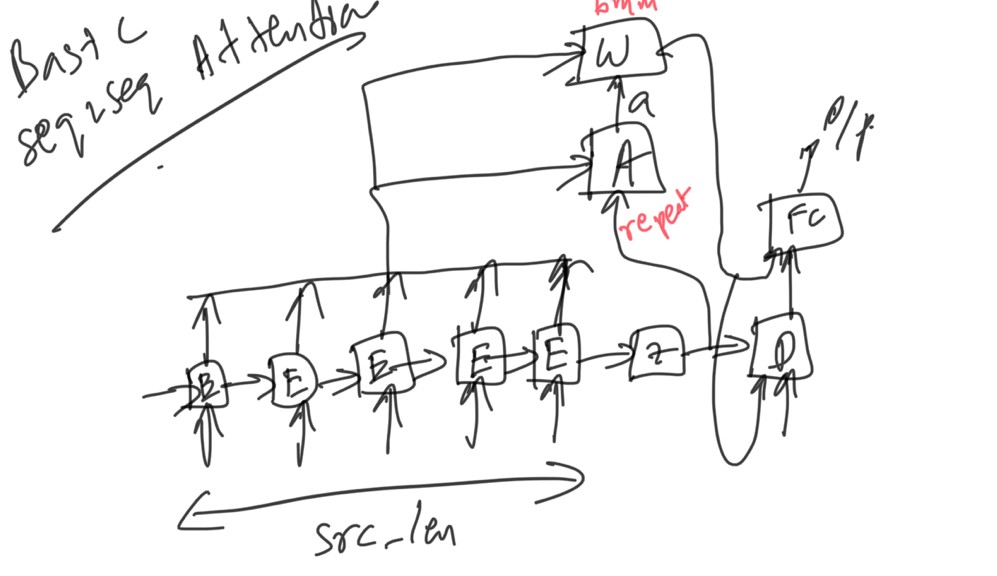

In [ ]:
from IPython.display import Image
Image('/usr/local/share/jupyter/nbextensions/att_seq2seq.jpg', width=700, height=400)

The above figure is abasic attention model with single encoder in a seq to seq model.
Block(A) will give the probability values for the input source length, which will be multiplied in Block(W) with theactual output vectors of the sourse sentence(one vertor for each time step), to give corresponding attention weightage.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim) #no dropout as only one layer!
        
        self.rnn = nn.GRU(emb_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded) #no cell state!
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim
        
        # self.embedding = nn.Embedding(output_dim, emb_dim)
        self.embedding = nn.Embedding.from_pretrained(word_vectors, freeze=True)
        
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, context):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #context = [n layers * n directions, batch size, hid dim]
        
        #n layers and n directions in the decoder will both always be 1, therefore:
        #hidden = [1, batch size, hid dim]
        #context = [1, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        # print(embedded.shape,context.shape)
                
        emb_con = torch.cat((embedded, context), dim = 2)
            
        #emb_con = [1, batch size, emb dim + hid dim]
            
        output, hidden = self.rnn(emb_con, hidden)
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), 
                           dim = 1)
        
        #output = [batch size, emb dim + hid dim * 2]
        
        prediction = self.fc_out(output)
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, encoder_q, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.encoder_q = encoder_q
        self.decoder = decoder
        self.device = device

        self.fc = nn.Linear(decoder.hid_dim * 2, decoder.hid_dim)
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        
    def forward(self, src, src_1, trg, teacher_forcing_ratio = 0.5):
        # print("src", src.shape,trg.shape)
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is the context
        context = self.encoder(src)
        ques = self.encoder_q(src_1)
        # print("cont ques", context.shape, ques.shape)
        # ([1, 128, 512]) torch.Size([1, 128, 512])

        
        #context also used as the initial hidden state of the decoder
        hidden = self.fc(torch.cat((ques, context), dim = 2))
        # print(hidden.shape)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and the context state
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, context)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

In [ ]:
INPUT_DIM = len(Context.vocab)
INPUT_DIM_Q = len(Question.vocab)
OUTPUT_DIM = len(Answer.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
enc_q = Encoder(INPUT_DIM_Q, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, enc_q, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(97315, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (encoder_q): Encoder(
    (embedding): Embedding(21052, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(18037, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=18037, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=1024, out_features=512, bias=True)
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 62,884,213 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = Answer.vocab.stoi[Answer.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
# for i, batch in enumerate(train_iterator):
#   print(batch.context[0].T.shape)
#   break

In [ ]:
# for i, batch in enumerate(valid_iterator):
#   print(batch.context[0].T.shape)
#   break

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.context[0]
        src_1 = batch.question[0]
        trg = batch.answer[0]
        
        optimizer.zero_grad()
        
        # print(src.shape, trg.shape)
        output = model(src, src_1, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].reshape(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            # src = batch.src.T
            # trg = batch.trg.T
            src = batch.context[0]
            src_1 = batch.question[0]
            trg = batch.answer[0]

            output = model(src, src_1, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].reshape(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import spacy
import numpy as np

import random
import math

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 2m 24s
	Train Loss: 6.746 | Train PPL: 850.465
	 Val. Loss: 6.530 |  Val. PPL: 685.659
Epoch: 02 | Time: 2m 24s
	Train Loss: 6.260 | Train PPL: 523.407
	 Val. Loss: 6.420 |  Val. PPL: 614.188
Epoch: 03 | Time: 2m 23s
	Train Loss: 5.855 | Train PPL: 348.819
	 Val. Loss: 6.436 |  Val. PPL: 624.122
Epoch: 04 | Time: 2m 23s
	Train Loss: 5.471 | Train PPL: 237.612
	 Val. Loss: 6.385 |  Val. PPL: 593.166
Epoch: 05 | Time: 2m 24s
	Train Loss: 5.096 | Train PPL: 163.343
	 Val. Loss: 6.503 |  Val. PPL: 667.370
Epoch: 06 | Time: 2m 23s
	Train Loss: 4.743 | Train PPL: 114.741
	 Val. Loss: 6.584 |  Val. PPL: 723.200
Epoch: 07 | Time: 2m 23s
	Train Loss: 4.375 | Train PPL:  79.463
	 Val. Loss: 6.648 |  Val. PPL: 771.117
Epoch: 08 | Time: 2m 24s
	Train Loss: 4.027 | Train PPL:  56.090
	 Val. Loss: 6.841 |  Val. PPL: 935.576
Epoch: 09 | Time: 2m 23s
	Train Loss: 3.714 | Train PPL:  41.033
	 Val. Loss: 6.976 |  Val. PPL: 1070.372
Epoch: 10 | Time: 2m 24s
	Train Loss: 3.403 | Train PP

In [ ]:
# Text.build_vocab(train, 
#                  max_size = MAX_VOCAB_SIZE, 
#                  #vectors = "glove.6B.100d", 
#                  vectors = "glove.840B.300d",
#                  unk_init = torch.Tensor.normal_)

In [ ]:
# pretrained_embeddings = Text.vocab.vectors
# print(pretrained_embeddings.shape)

# model.embedding.weight.data.copy_(pretrained_embeddings)

